In [11]:
import numpy as np
import pandas as pd
import scipy as sc
import re
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import cross_val_score, train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
import scipy.linalg
import functools
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

count      5000.00000
mean       9189.71360
std       19510.23063
min           1.00000
25%        1191.00000
50%        2887.50000
75%        8278.50000
max      378795.00000
Name: Words, dtype: float64


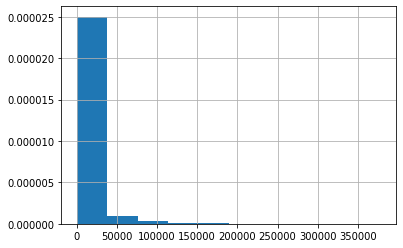

In [12]:
#Analyse unidimensionnelle Bastien LEVEILLE
#Le nombre de mots
HPData = pd.read_csv(r"finalHPData.csv")
print(HPData['Words'].describe())
HPData["Words"].hist(density = True)        

In [ ]:
#Analyse unidimensionnel Gaël LODE
#quels sont les personnages les plus récurrent ?
print(HPData['Characters'].describe())
HPData["Characters"].value_counts(normalize=True).plot(kind='pie')

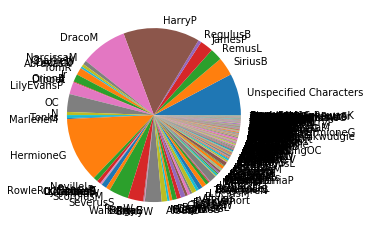

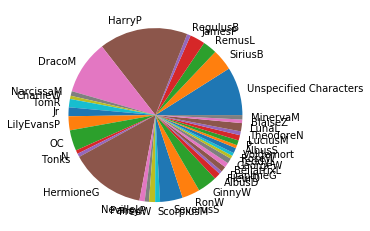

In [8]:
#Ce n'est pas très lisible, Fanfiction.net autorosiant à indiquer au plus 4 personnages nous avons alors toutes 
#les combinaisons possible de 0 - 4 personnages dans n'importe quelle ordre
#essayons de les récuperer de manière individuelle, les info dans Characters sont des string séparé par des ','
charactersmap = {
    "Unspecified Characters" : 0
}
for i in range(len(HPData["Characters"])):
    val = HPData["Characters"][i]
    valsplit = re.split('[,.]',val)
    for j in range(len(valsplit)):
        if valsplit[j]!='':
            if valsplit[j] in charactersmap :
                charactersmap[valsplit[j]]+=1
            else:
                charactersmap[valsplit[j]]=1
charlab = charactersmap.keys()
charval = charactersmap.values()
plt.pie(charval,labels = charlab)
plt.show() 
# c'est tous de suite un peu plus lisibles
#on va maintenant supprimer tous les personnages qui apparaissent que dans 1% des fanfictions de notre échantillons
bcharmap = charactersmap.copy()
for i in bcharmap:
    if charactersmap[i] < 50:
        charactersmap.pop(i)
charlab = charactersmap.keys()
charval = charactersmap.values()
plt.pie(charval,labels = charlab)
plt.show() 

(0.7307790227283013, 0.0)


[]

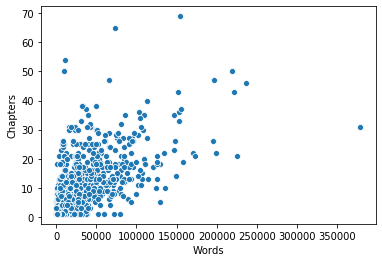

In [9]:
#Analyse bidimensionnelle Gaël LODE
#Le nombre de mots par rapport au nombre de Chapitre
x= HPData['Words']
y=HPData['Chapters']
sns.scatterplot(x,y)
print(sc.stats.pearsonr(x,y))
plt.plot()

In [ ]:
#Modèle clustering Bastien LEVEILLE
print(HPData.dtypes)
print(HPData['Author'].describe())
print(HPData['Characters'].describe())


In [13]:

# code MCA2.py du tp1 

def dummy(DF, cols=None):
    """Dummy code select columns of a DataFrame."""
    return pd.concat((pd.get_dummies(DF[col]) for col in (DF.columns if cols is None else cols)),
                        axis=1, keys = DF.columns)

def _mul(*args):
    """An internal method to multiply matrices."""
    return functools.reduce(np.dot, args)

class mca:
    """Run MCA on selected columns of a pandas DataFrame.
    If the column are specified, assume that they hold
    categorical variables that need to be replaced with
    dummy indicators, otherwise process the DataFrame as is.

    'cols': The columns of the DataFrame to process.
    'K': The number of columns before dummy coding. To be passed if cols isn't.
    'benzecri': Perform Benzécri correction (default: True)
    'TOL': value below which to round eigenvalues to zero
    """

    def __init__(self, DF, cols=None, ncols=None, benzecri=True, TOL=1e-4):

        if cols: # if you want us to do the dummy coding
            K = len(cols) # the number of categories
            X = dummy(DF, cols)
        else: # if you want to dummy code it yourself or do all the cols
            K = ncols
            if ncols is None: # be sure to pass K if you did not multi-index
                K = len(DF.columns) # ... it with mca.dummy()
                if not K: raise ValueError("Your DataFrame has no columns.")
            elif not isinstance(ncols, int) or ncols<=0 or ncols>len(DF.columns): # if you dummy coded it yourself
                raise ValueError("You must pass a valid number of columns.")
            X = DF
        S = X.sum().sum()
        Z = X/S # correspondence matrix
        self.r = Z.sum(axis=1)
        self.c = Z.sum()
        self._numitems = len(DF)
        self.cor = benzecri
        self.D_r = np.diag(1/np.sqrt(self.r))
        Z_c = Z - np.outer(self.r,self.c) # standardized residuals matrix
        self.D_c = np.diag(1/np.sqrt(self.c))

        # another option, not pursued here, is sklearn.decomposition.TruncatedSVD
        self.P, self.s, self.Q = scipy.linalg.svd(_mul(self.D_r, Z_c, self.D_c))

        if benzecri: self.E = np.array([(K/(K-1)*(_ - 1/K))**2
                if _ > 1/K else 0 for _ in self.s**2])
        self.inertia = self.E.sum() if benzecri else sum(self.s**2)
        self.rank = np.argmax((self.E if benzecri else self.s**2) < TOL)
        self.L = (self.E if benzecri else self.s**2)[:self.rank]

    def fs_r(self, percent=0.9, N=None):
        """Get the row factor scores (dimensionality-reduced representation),
        choosing how many factors to retain, directly or based on the explained variance.

        'percent': The minimum variance that the retained factors are required
                    to explain (default: 90% = 0.9)
        'N': The number of factors to retain. Overrides 'percent'.
            If the rank is less than N, N is ignored.
        """
        if not 0 <= percent <= 1:
            raise ValueError("Percent should be a real number between 0 and 1.")
        if N:
            if not isinstance(N, (int, np.int64)) or N<=0:
                raise ValueError("N should be a positive integer.")
            N = min(N, self.rank)
            # S = numpy.zeros((self._numitems, N))
        # else:
        self.k = 1 + np.flatnonzero(np.cumsum(self.L) >= sum(self.L)*percent)[0]
            # S = numpy.zeros((self._numitems, self.k))
        # the sign of the square root can be either way; singular value vs. eigenvalue
        # numpy.fill_diagonal(S, -numpy.sqrt(self.E) if self.cor else self.s)
        num2ret = N if N else self.k
        s = -np.sqrt(self.L) if self.cor else self.s
        S = scipy.linalg.diagsvd(s[:num2ret], self._numitems, num2ret)
        self.F = _mul(self.D_r, self.P, S)
        return self.F

    def fs_c(self, percent=0.9, N=None):
        """Get the column factor scores (dimensionality-reduced representation),
        choosing how many factors to retain, directly or based on the explained variance.

        'percent': The minimum variance that the retained factors are required
                    to explain (default: 90% = 0.9)
        'N': The number of factors to retain. Overrides 'percent'.
            If the rank is less than N, N is ignored.
        """
        if not 0 <= percent <= 1:
            raise ValueError("Percent should be a real number between 0 and 1.")
        if N:
            if not isinstance(N, (int, np.int64)) or N<=0:
                raise ValueError("N should be a positive integer.")
            N = min(N, self.rank) # maybe we should notify the user?
            # S = numpy.zeros((self._numitems, N))
        # else:
        self.k = 1 + np.flatnonzero(np.cumsum(self.L) >= sum(self.L)*percent)[0]
            # S = numpy.zeros((self._numitems, self.k))
        # the sign of the square root can be either way; singular value vs. eigenvalue
        # numpy.fill_diagonal(S, -numpy.sqrt(self.E) if self.cor else self.s)
        num2ret = N if N else self.k
        s = -np.sqrt(self.L) if self.cor else self.s
        S = scipy.linalg.diagsvd(s[:num2ret], len(self.Q), num2ret)
        self.G =  _mul(self.D_c, self.Q.T, S) # important! note the transpose on Q
        return self.G

    def cos_r(self, N=None): #percent=0.9,
        """Return the squared cosines for each row."""

        if not hasattr(self, 'F') or self.F.shape[1] < self.rank:
            self.fs_r(N=self.rank) # generate F
        self.dr = np.linalg.norm(self.F, axis=1)**2
        # cheaper than numpy.diag(self.F.dot(self.F.T))?

        return np.apply_along_axis(lambda _: _/self.dr, 0, self.F[:,:N]**2)

    def cos_c(self, N=None): #percent=0.9,
        """Return the squared cosines for each column."""

        if not hasattr(self, 'G') or self.G.shape[1] < self.rank:
            self.fs_c(N=self.rank) # generate G
        self.dc = np.linalg.norm(self.G, axis=1)**2
        # cheaper than numpy.diag(self.G.dot(self.G.T))?

        return np.apply_along_axis(lambda _: _/self.dc, 0, self.G[:,:N]**2)

    def cont_r(self, percent=0.9, N=None):
        """Return the contribution of each row."""

        if not hasattr(self, 'F'): self.fs_r(N=self.rank) # generate F
        return np.apply_along_axis(lambda _: _/self.L[:N], 1,
            np.apply_along_axis(lambda _: _*self.r, 0, self.F[:,:N]**2))

    def cont_c(self, percent=0.9, N=None): # bug? check axis number 0 vs 1 here
        """Return the contribution of each row."""

        if not hasattr(self, 'G'): self.fs_c(N=self.rank) # generate G
        return np.apply_along_axis(lambda _: _/self.L[:N], 1,
            np.apply_along_axis(lambda _: _*self.c, 0, self.G[:,:N]**2))

    def fs_r_sup(self, DF, ncols=None):
        """Find the supplementary row factor scores.

        ncols: The number of singular vectors to retain.
        If both are passed, cols is given preference.
        """
        if not hasattr(self, 'G'): self.fs_c(N=self.rank) # generate G

        if ncols and (not isinstance(ncols, int) or ncols<=0):
            raise ValueError("ncols should be a positive integer.")
        s = -np.sqrt(self.E) if self.cor else self.s
        N = min(ncols, self.rank) if ncols else self.rank
        S_inv = scipy.linalg.diagsvd(-1/s[:N], len(self.G.T), N)
        # S = scipy.linalg.diagsvd(s[:N], len(self.tau), N)
        return _mul(DF.div(DF.sum(axis=1), axis=0), self.G, S_inv)[:,:N]

    def fs_c_sup(self, DF, ncols=None):
        """Find the supplementary column factor scores.

        ncols: The number of singular vectors to retain.
        If both are passed, cols is given preference.
        """
        if not hasattr(self, 'F'): self.fs_r(N=self.rank) # generate F

        if ncols and (not isinstance(ncols, int) or ncols<=0):
            raise ValueError("ncols should be a positive integer.")
        s = -np.sqrt(self.E) if self.cor else self.s
        N = min(ncols, self.rank) if ncols else self.rank
        S_inv = scipy.linalg.diagsvd(-1/s[:N], len(self.F.T), N)
        # S = scipy.linalg.diagsvd(s[:N], len(self.tau), N)
        return _mul((DF/DF.sum()).T, self.F, S_inv)[:,:N]

In [37]:
dfbin=pd.get_dummies(HPData.iloc[:1000,:16])  #pour binariser les variables catégoriques (one-hot-encoding) 
dfbin.shape
dfbin.dtypes
acm=mca(dfbin,benzecri=False)   # on fait l'ACM
nouvellesVariables=acm.fs_r(N=16)
nouvellesVariables.shape
df = pd.DataFrame(data=nouvellesVariables)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-0.001927,0.004312,-0.003597,0.002090,-0.001928,0.003535,-0.002828,0.000303,-0.000223,0.074299,-0.021187,0.029062,-0.002314,0.002114,-0.002637,-0.001128
1,-0.002643,0.002246,-0.003509,0.001871,-0.001810,0.003903,-0.003327,0.000832,-0.001023,0.076502,-0.021051,0.029583,-0.005346,0.002444,-0.002901,-0.001926
2,-0.002721,0.003261,-0.003299,0.001917,-0.001655,0.003893,-0.003405,0.000944,-0.000917,0.071621,-0.019827,0.027732,-0.003809,0.002568,-0.002998,-0.001939
3,-0.002299,0.004569,-0.002893,0.001469,-0.001363,0.003671,-0.003020,0.000645,-0.000659,0.077191,-0.021840,0.030764,-0.003085,0.002074,-0.002727,-0.001532
4,0.001638,0.027254,0.017088,-0.003537,0.003643,-0.000831,0.015403,-0.000309,0.008290,0.026094,-0.026715,0.021481,0.041667,-0.006479,0.003074,0.003264


In [79]:
#Mise en place du testing set et du training
x = df
y = HPData["Words"].iloc[:1000]
x = np.array(x)
y = np.array(y)
x, y = shuffle(x, y)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.7, random_state=0)

In [80]:
#Modele clustering
# n_neighbors = nombre de voisin par défaut utiliser par défaut pour la recherche par k voisins
knn = KNeighborsClassifier(n_neighbors=13)
knn.fit(x_train, y_train)
KNeighborsClassifier()

score = knn.score(x_test, y_test) # avec validation simple
print(score)

0.0014285714285714286


In [82]:
#Scoring

scoring = precision_recall_fscore_support(y_test, knn.predict(x_test))

print("precision: " + str(scoring[0]))
print("recall: " + str(scoring[1]))
print("fbeta_score: " + str(scoring[2]))
print("support: " + str(scoring[3]))



precision: [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  

C:\Users\Bastien\Anaconda3\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Bastien\Anaconda3\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
